<a href="https://colab.research.google.com/github/weilainicolas/Deep-Learning/blob/master/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import untar_data, URLs

In [ ]:
import pandas as pd

In [ ]:
path=untar_data(URLs.ML_SAMPLE)
ratings=pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [ ]:
import torch
from torch import nn

In [ ]:
ratings.rating.value_counts()

4.0    1769
5.0    1273
3.0     988
3.5     678
4.5     643
2.0     287
2.5     206
1.0     104
1.5      59
0.5      24
Name: rating, dtype: int64

In [ ]:
ratings.rating=(ratings.rating.apply(float)-2.5)/5

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,7,51,0.3,1255504951
1,80,47,0.2,1172695223
2,20,13,0.2,1291598691
3,47,59,0.5,957481884
4,17,16,-0.1,1138999234


In [ ]:
class MovieDataSet():
  def __init__(self,users, movies, ratings):
    self.users=users
    self.movies=movies
    self.ratings=ratings

  def __len__(self):
    return len(self.movies)

  def __getitem__(self, index):
    users=self.users[index]
    movies=self.movies[index]
    ratings=self.ratings[index]
    return {
        'users':torch.tensor(users,dtype=torch.long),
        'movies':torch.tensor(movies,dtype=torch.long),
        'ratings':torch.tensor(ratings),
    }


In [ ]:
class CFmodel(nn.Module):
  def __init__(self,num_users, num_movies):
    super().__init__()
    self.user_embd=nn.Embedding(num_users, 64)
    self.movie_embd=nn.Embedding(num_movies,64)
    self.out = nn.Sequential(
        nn.Linear(128,256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64,16),
        nn.ReLU(),
        nn.Linear(16,1)
    )


  def forward(self,users, movies, ratings=None):
    user_embds=self.user_embd(users)
    movie_embds=self.movie_embd(movies)
    output =torch.cat([user_embds, movie_embds],dim=1)
    output = self.out(output)
    return output


In [ ]:
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection, metrics, preprocessing

In [ ]:
encoder=preprocessing.LabelEncoder()
ratings.userId=encoder.fit_transform(ratings.userId.values)
ratings.movieId=encoder.fit_transform(ratings.movieId.values)

In [ ]:
df_train, df_valid = model_selection.train_test_split(
    ratings, test_size=0.1, random_state=42, stratify=ratings.rating.values
)
train_Dataset= MovieDataSet(df_train.userId.values,
                            df_train.movieId.values,
                            df_train.rating.values)

valid_Dataset= MovieDataSet(df_valid.userId.values,
                            df_valid.movieId.values,
                            df_valid.rating.values)

In [ ]:
train_dataloader=DataLoader(dataset=train_Dataset,
                            batch_size=100,
                            shuffle=True,
                            num_workers=2)

valid_dataloader=DataLoader(dataset=valid_Dataset,
                            batch_size=100,
                            shuffle=True,
                            num_workers=2)




In [ ]:
model=CFmodel(len(ratings.userId.unique()),len(ratings.movieId.unique()))
loss_func=nn.MSELoss()


In [ ]:
optimizer=torch.optim.Adam(model.parameters())
loss_list=[]

In [ ]:
for i, batch in enumerate(train_dataloader):
  output=model(batch['users'],batch['movies'])
  actual=batch['ratings'].view(len(batch['ratings']),-1).float()
  loss=loss_func(output, actual)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loss_list.append(loss.item())
  print(f"batch #{i:05d}: loss {loss.item()}")


batch #00000: loss 0.008329365402460098
batch #00001: loss 0.006773332133889198
batch #00002: loss 0.006874730810523033
batch #00003: loss 0.007125841919332743
batch #00004: loss 0.005939670838415623
batch #00005: loss 0.0064153182320296764
batch #00006: loss 0.007506504654884338
batch #00007: loss 0.007128656376153231
batch #00008: loss 0.0062896027229726315
batch #00009: loss 0.007202428765594959
batch #00010: loss 0.007332216016948223
batch #00011: loss 0.008748456835746765
batch #00012: loss 0.007567946333438158
batch #00013: loss 0.005651683080941439
batch #00014: loss 0.008858189918100834
batch #00015: loss 0.008316011168062687
batch #00016: loss 0.0071313707157969475
batch #00017: loss 0.007360098883509636
batch #00018: loss 0.007547018118202686
batch #00019: loss 0.007507659960538149
batch #00020: loss 0.0064244382083415985
batch #00021: loss 0.00826234370470047
batch #00022: loss 0.007960218004882336
batch #00023: loss 0.00770980678498745
batch #00024: loss 0.00603406177833676

In [ ]:
from matplotlib import pyplot as plt

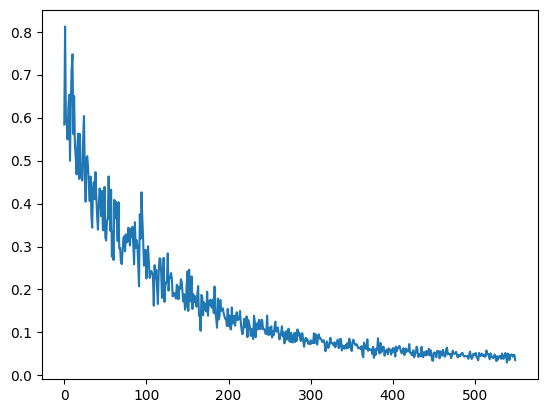

In [ ]:
plt.plot(loss_list)

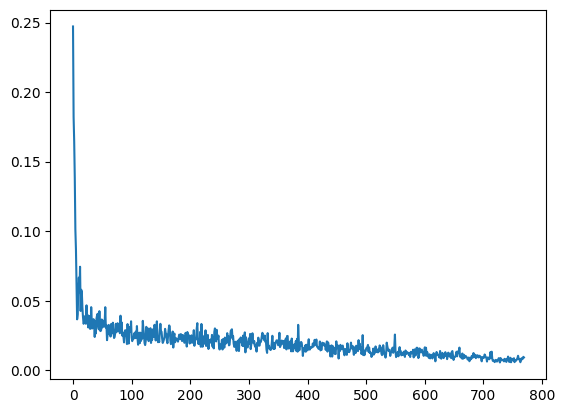

In [ ]:
plt.plot(loss_list)

In [ ]:
valid_loss_list=[]
with torch.no_grad():
  for batch in valid_dataloader:
    predict = model(batch['users'],batch['movies'])
    actual=batch["ratings"].view(len(batch['ratings']), -1)
    loss=(predict-actual).abs().squeeze()
    valid_loss_list.extend(loss.tolist())

In [ ]:
torch.tensor(valid_loss_list).mean()

tensor(0.1702)

In [ ]:
torch.tensor(valid_loss_list).mean()

tensor(0.1239)